In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
from matplotlib import animation
from dataclasses import dataclass
from typing import List, Dict, Iterable, Optional


# Parámetros

In [2]:
# Constantes globales (usadas en bloques siguientes)
VMAX = 1.0   # velocidad máxima (mochila vacía)
VMIN = 0.1   # velocidad mínima (mochila llena)
WMAX = 100.0  # peso máximo de la mochila
n = 8        # número de ciudades
start = 5    # ciudad de inicio
R = 1       # Ratio de beneficio/costo

# Crear Grafos

In [3]:
def crear_kn_distancias(
    n: int,
    dibujar: bool = True,
    layout: str = "circular",
    seed: int = 42,
    aleatorio: bool = True,
    min_dist: float = 1.0,
    max_dist: float = 10.0,
    matriz_distancias: np.ndarray | None = None,
):
    """
    Crea un grafo completo K_n (2 ≤ n ≤ 8).

    - Si matriz_distancias no es None, la usa tal cual (se asume cuadrada n×n).
    - Si matriz_distancias es None y aleatorio=True, genera distancias aleatorias
      simétricas en [min_dist, max_dist].
    - Si aleatorio=False, todas las distancias son 1 (versión antigua).

    Devuelve:
      - distances: matriz numpy (n x n) con 0 en diagonal
      - G: networkx.Graph con pesos 'weight' = distances[u,v]
    """
    if not (2 <= n <= 8):
        raise ValueError("n debe estar entre 2 y 8 (K_8 como máximo).")

    # --- Construir matriz de distancias ---
    if matriz_distancias is not None:
        distances = np.array(matriz_distancias, dtype=float)
        if distances.shape != (n, n):
            raise ValueError("matriz_distancias debe ser de tamaño (n, n)")
        # Asegurar diagonal 0
        np.fill_diagonal(distances, 0.0)
    else:
        if aleatorio:
            rng = np.random.default_rng(seed)
            distances = rng.uniform(min_dist, max_dist, size=(n, n))
            # Hacerla simétrica
            distances = (distances + distances.T) / 2.0
            np.fill_diagonal(distances, 0.0)
        else:
            distances = np.ones((n, n), dtype=float)
            np.fill_diagonal(distances, 0.0)

    # --- Grafo completo con esos pesos ---
    G = nx.complete_graph(n)
    for u, v in G.edges():
        G[u][v]['weight'] = float(distances[u, v])

    # --- Dibujo opcional ---
    if dibujar:
        if layout == "spring":
            pos = nx.spring_layout(G, seed=seed)
        elif layout == "kamada":
            pos = nx.kamada_kawai_layout(G)
        else:
            pos = nx.circular_layout(G)

        plt.figure(figsize=(4, 4))
        nx.draw(
            G, pos,
            with_labels=True,
            node_size=800,
            node_color="#93c5fd",
            edgecolors="#1f2937",
            linewidths=1.5,
            width=1.5,
        )

        # Etiquetas con las distancias
        edge_labels = {
            (u, v): f"{G[u][v]['weight']:.1f}" for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

        plt.title(f"Grafo completo K_{n}", fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    return distances, G


def imprimir_matriz_numpy(dist):
    """Imprime la matriz de distancias en formato legible."""
    n = dist.shape[0]
    for i in range(n):
        fila = " ".join(f"{dist[i,j]:4.1f}" for j in range(n))
        print(f"[{i:02d}] {fila}")



# Crear Items

In [4]:
@dataclass
class Item:
    id: int
    value: float
    weight: float
    name: str = ""   # nuevo campo opcional

nul = Item(id=-1, value=0.0, weight=0.0, name="Nulo")

C:\Users\crist\AppData\Local\Temp\ipykernel_23968\1060348279.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


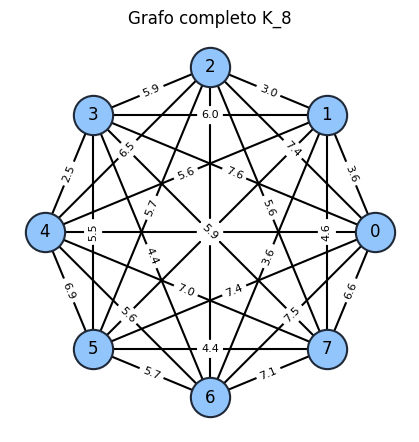

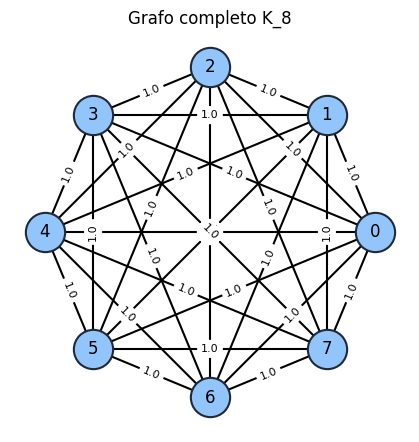

In [5]:
# Grafo con distancias aleatorias entre 1 y 20
distances, G = crear_kn_distancias(n, aleatorio=True, min_dist=1.0, max_dist=10.0)

# Grafo con TODAS las distancias = 1 (comportamiento viejo)
distances, G = crear_kn_distancias(n, aleatorio=False)

# Grafo usando una matriz que la persona mismo diseñó
mi_matriz = np.array([
    [0, 5, 2],
    [5, 0, 7],
    [2, 7, 0],
], dtype=float)

In [6]:
items_genericos = [
    Item(id=0, value=100,   weight=80.0, name="Valioso Pesado"),
    Item(id=1, value=100,   weight=10.0, name="Valioso Ligero"),
    Item(id=2, value=20,    weight=80.0, name="Mundano Pesado"),
    Item(id=3, value=20,    weight=10.0, name="Mundano Ligero")
    ]

# Configurar Velocidad

In [7]:
def velocidad_por_peso(Wc, W_max=WMAX, vmax=VMAX, vmin=VMIN):
    """
    Velocidad lineal del TTP:
        v = vmax - (Wc / W_max) * (vmax - vmin)
    Restringe la fracción a [0,1] para evitar valores fuera de rango.
    """
    if W_max <= 0:
        raise ValueError("WMAX debe ser > 0")
    frac = Wc / W_max
    if frac < 0:   frac = 0.0
    if frac > 1:   frac = 1.0
    return vmax - frac * (vmax - vmin)

def tiempo_de_tramo(distancia, Wc, W_max=WMAX, vmax=VMAX, vmin=VMIN):
    """
    Tiempo = distancia / velocidad_actual.
    """
    v = velocidad_por_peso(Wc, W_max, vmax, vmin)
    if v <= 0:
        raise ValueError("La velocidad debe ser positiva.")
    return distancia / v

def tiempo_total_tour(distances, tour, Wc_constante, W_max=WMAX, vmax=VMAX, vmin=VMIN):
    """
    Calcula el tiempo total de un tour circular usando un Wc fijo en todo el recorrido.
    Esto sirve solo para probar el efecto del peso en los tiempos.
    """
    n = len(tour)
    total = 0.0
    for i in range(n):
        a = tour[i]
        b = tour[(i+1) % n]
        d = distances[a, b]
        total += tiempo_de_tramo(d, Wc_constante, W_max, vmax, vmin)
    return total

def tiempo_total_tour_con_evolucion(distances, tour, perfil_Wc, W_max=WMAX, vmax=VMAX, vmin=VMIN):
    """
    Variante donde se entrega un perfil de pesos Wc (peso que lleva ANTES de cada tramo).
    perfil_Wc debe tener la misma longitud que tour.
    """
    if len(perfil_Wc) != len(tour):
        raise ValueError("perfil_Wc debe tener la misma longitud que tour.")
    n = len(tour)
    total = 0.0
    for i in range(n):
        a = tour[i]
        b = tour[(i+1) % n]
        d = distances[a, b]
        total += tiempo_de_tramo(d, perfil_Wc[i], W_max, vmax, vmin)
    return total

# Tours

In [8]:
def generar_tours(n: int, start: int = 0):
    """
    Genera todos los tours posibles que:
    - empiezan en 'start'
    - visitan cada ciudad exactamente una vez
    - vuelven implícitamente a 'start' (eso ya lo hace evaluar_ttp)
    Ejemplo para n=4, start=0:
      [0,1,2,3], [0,1,3,2], [0,2,1,3], ...
    """
    otras = [i for i in range(n) if i != start]
    for perm in itertools.permutations(otras):
        yield [start] + list(perm)

def tour_trivial(n: int, start: int = 0) -> List[int]:
    """
    Tour que recorre las ciudades en orden, partiendo en 'start'.
    Ej: n=5, start=0 -> [0,1,2,3,4]
        n=5, start=2 -> [2,3,4,0,1]
    """
    return [(start + i) % n for i in range(n)]

def tour_aleatorio(n: int, start: int = 0, seed: int | None = None) -> List[int]:
    """
    Genera un tour aleatorio que comienza en 'start'.
    """
    rng = np.random.default_rng(seed)
    otras = [i for i in range(n) if i != start]
    rng.shuffle(otras)
    return [start] + otras

def tour_vecino_mas_cercano(distances: np.ndarray, start: int = 0) -> List[int]:
    """
    Construye un tour usando la heurística de vecino más cercano.
    NO es óptimo en general, pero es rápido y da un buen punto de partida.
    """
    n = distances.shape[0]
    no_visitadas = set(range(n))
    no_visitadas.remove(start)
    tour = [start]
    actual = start

    while no_visitadas:
        siguiente = min(no_visitadas, key=lambda j: distances[actual, j])
        no_visitadas.remove(siguiente)
        tour.append(siguiente)
        actual = siguiente

    return tour


# Ciudades

In [9]:
@dataclass
class Ciudad:
    id: int
    Num_items: int
    lista_items: List[Item]
    name: str = ""

null = Ciudad(id=-1, name="Null", Num_items=0, lista_items=[])

def generar_ciudades(
    n_ciudades: int,
    seed: Optional[int] = None
) -> List[Ciudad]:
    """Genera lista de Ciudad con id y name."""
    if seed is not None:
        random.seed(seed)

    ciudades = []
    for i in range(n_ciudades):
        ciudades.append(Ciudad(id=i, name=f"Ciudad_{i}", Num_items=0, lista_items=[]))
    return ciudades

def generar_ciudades_con_nulls(
    ciudades: List[Ciudad],
    seed: Optional[int] = None
) -> List[Ciudad]:
    """Asigna items a ciudades y devuelve lista de Ciudad."""
    if seed is not None:
        random.seed(seed)

    ciudades0 = ciudades.copy()

    for c in ciudades0:
        r = random.random()
        if r < 0.4:
            c.Num_items = 1
            c.lista_items = [nul]
        elif r < 0.7:
            c.Num_items = 2
            c.lista_items = [nul,nul]
        else:
            c.Num_items = 3
            c.lista_items = [nul,nul,nul]

    return ciudades0


def reemplazar_nuls_por_items(ciudad, items):
    """
    Reemplaza cada 'null' (ítem con id == -1) en ciudad.lista_items
    por un ítem real elegido al azar desde 'items'.

    La cantidad total de slots no cambia.
    Permite repetidos.
    Devuelve la ciudad actualizada.
    """

    nueva_lista = []
    for it in ciudad.lista_items:
        if it.id == -1:                     # es un null → reemplazar
            nuevo = random.choice(items)
            nueva_lista.append(nuevo)
        else:
            nueva_lista.append(it)          # mantener ítems reales

    ciudad.lista_items = nueva_lista
    ciudad.Num_items = len(nueva_lista)

    return ciudad




# Evaluar

In [10]:
def evaluar_ttp1_offline(
    distances: np.ndarray,
    tour: list[int],
    ciudades: list[Ciudad],
    items: list[Item],
    W_max: float,
    R: float,
    picking_policy: str = "greedy",
):
    """
    Evalúa un tour para el TTP1 OFFLINE.

    - Las ciudades ya tienen sus items fijos en `lista_items`.
    - Se recorre el tour y en cada ciudad se decide qué ítems tomar,
      según `picking_policy`:
        * "all"      : tomar todos en el orden dado mientras quepan.
        * "greedy"   : tomar por mejor razón value/weight mientras quepan.
        * "exchange" : como greedy, pero permite intercambios locales
                       (sacar ítems peores para meter mejores), sin
                       violar la capacidad.

    Devuelve un dict con:
        total_value, total_time, final_benefit,
        picked_ids, pickup_log, knapsack_log.
    """

    n = distances.shape[0]
    Wc = 0.0          # peso actual en la mochila
    total_value = 0.0
    total_time = 0.0
    picked_ids: set[int] = set()
    pickup_log: list[tuple[int, list[int]]] = []
    knapsack_log: list[tuple[int, list[int]]] = []

    eps = 1e-9

    # diccionarios de acceso rápido
    item_by_id = {it.id: it for it in items}
    ciudades_by_id = {c.id: c for c in ciudades}

    # función auxiliar: razón valor/peso
    def ratio(it: Item) -> float:
        return it.value / it.weight if it.weight > 0 else 0.0

    for i in range(len(tour)):
        cur = tour[i]
        nxt = tour[(i + 1) % len(tour)]
        ciudad = ciudades_by_id[cur]
        

        # --- Reemplazar nulls SOLO si existen ---
        if any(it.id == -1 for it in ciudad.lista_items):
            ciudad = reemplazar_nuls_por_items(ciudad, items)


        # --- Ítems disponibles en esta ciudad ---
        items_en_ciudad = [
            it for it in ciudad.lista_items
            if it.id != -1
        ]
        
        tomados: list[int] = []      # ids añadidos en esta ciudad
        drop_ids: list[int] = []     # ids removidos (solo exchange)

        # --- Política ALL: tomar en el orden dado mientras quepan ---
        if picking_policy == "all":
            for it in items_en_ciudad:
                if Wc + it.weight <= W_max + eps:
                    Wc += it.weight
                    total_value += it.value
                    picked_ids.add(it.id)
                    tomados.append(it.id)

        # --- Política GREEDY: ordenar por razón valor/peso y tomar ---
        elif picking_policy == "greedy":
            ordenados = sorted(items_en_ciudad, key=ratio, reverse=True)
            for it in ordenados:
                if Wc + it.weight <= W_max + eps:
                    Wc += it.weight
                    total_value += it.value
                    picked_ids.add(it.id)
                    tomados.append(it.id)

        # --- Política EXCHANGE: permitir intercambios locales ---
        elif picking_policy == "exchange":
            # ítems candidatos, ordenados por ratio descendente
            candidatos = sorted(items_en_ciudad, key=ratio, reverse=True)

            def mochila_items() -> list[Item]:
                return [item_by_id[j] for j in picked_ids]

            for it in candidatos:
                # 1) ¿cabe directamente?
                if Wc + it.weight <= W_max + eps:
                    Wc += it.weight
                    total_value += it.value
                    picked_ids.add(it.id)
                    tomados.append(it.id)
                    continue

                # 2) Probar intercambios con ítems actuales de peor ratio
                actuales = mochila_items()
                opciones: list[tuple[Item, float]] = []  # (old_item, nuevo_Wc)

                for old in actuales:
                    if ratio(old) < ratio(it):
                        nuevo_Wc = Wc - old.weight + it.weight
                        if nuevo_Wc <= W_max + eps:
                            opciones.append((old, nuevo_Wc))

                if not opciones:
                    # no se encontró intercambio factible
                    continue

                # elegir el ítem viejo con peor ratio entre las opciones
                old, nuevo_Wc = min(opciones, key=lambda par: ratio(par[0]))

                # aplicar intercambio: sacar old, meter it
                picked_ids.remove(old.id)
                Wc -= old.weight
                total_value -= old.value
                drop_ids.append(old.id)

                picked_ids.add(it.id)
                Wc = nuevo_Wc
                total_value += it.value
                tomados.append(it.id)

        else:
            # política desconocida → no tomar nada
            pass

        # registrar movimientos en esta ciudad
        pickup_log.append((cur, tomados))
        knapsack_log.append((cur, sorted(picked_ids)))

        # --- Viaje al siguiente nodo con el peso actual Wc ---
        d = distances[cur, nxt]
        total_time += tiempo_de_tramo(d, Wc, W_max, vmax=VMAX, vmin=VMIN)

    final_benefit = total_value - R * total_time

    return {
        "total_value": total_value,
        "total_time": total_time,
        "final_benefit": final_benefit,
        "picked_ids": picked_ids,
        "pickup_log": pickup_log,
        "knapsack_log": knapsack_log,
    }


In [11]:
def mejor_tour_ttp1_offline(
    distances: np.ndarray,
    ciudades: List[Ciudad],
    items: List[Item],
    W_max: float,
    R: float,
    picking_policy: str = "greedy",
    start: int = 0,
):
    """
    Busca el mejor tour para el TTP, probando todos los tours que empiezan en 'start'.

    Usa la función evaluar_ttp(distances, tour, items, W_max, R, picking_policy)
    que ya está implementada.

    Devuelve:
      - best_tour: lista de ciudades en orden
      - best_eval: dict con total_value, total_time, final_benefit, etc.
    """
    n = distances.shape[0]
    best_tour = None
    best_eval = None

    for tour in generar_tours(n, start=start):
        res = evaluar_ttp1_offline(distances, tour, ciudades, items, W_max, R, picking_policy=picking_policy)
        if (best_eval is None) or (res["final_benefit"] > best_eval["final_benefit"]):
            best_eval = res
            best_tour = tour

    return best_tour, best_eval

C:\Users\crist\AppData\Local\Temp\ipykernel_23968\1060348279.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


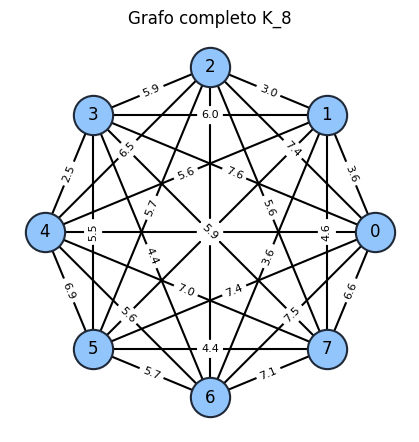

Tour: [0, 7, 1, 4, 6, 5, 3, 2]

--- Política: ALL (tomar todo si cabe) ---
Valor total  : 220.0
Tiempo total : 388.943082685439
Beneficio    : -168.94308268543898
Log picking  : [(0, [3, 0]), (7, []), (1, []), (4, [1]), (6, []), (5, []), (3, []), (2, [])]
Knapsack log : [0, 1, 3]

--- Política: GREEDY (por valor/peso) ---
Valor total  : 220.0
Tiempo total : 388.943082685439
Beneficio    : -168.94308268543898
Log picking  : [(0, [3, 0]), (7, []), (1, []), (4, [1]), (6, []), (5, []), (3, []), (2, [])]
Knapsack log : [0, 1, 3]

--- Política: EXCHANGE (intercambios locales) ---
Valor total  : 560.0
Tiempo total : 165.39329001214793
Beneficio    : 394.60670998785207
Log picking  : [(0, [3, 0]), (7, []), (1, []), (4, [1, 1]), (6, [1, 1, 3]), (5, [3]), (3, []), (2, [1])]
Knapsack log : [1, 3]


In [12]:
# 1) Instancia pequeña
distances, _ = crear_kn_distancias(n)  # K_n con distancias = 1
tour = list(range(n))                  # tour circular 0-1-2-3-4-5-6-7-8-0
random.shuffle(tour)

ciudades = generar_ciudades(n, seed=42)
ciudades_con_items = generar_ciudades_con_nulls(ciudades, seed=42)

# 4) Evaluar con dos políticas

res_grd = evaluar_ttp1_offline(distances, tour, ciudades_con_items, items_genericos, WMAX, R, picking_policy="greedy")
res_all = evaluar_ttp1_offline(distances, tour, ciudades_con_items, items_genericos, WMAX, R, picking_policy="all")
res_exch = evaluar_ttp1_offline(distances, tour, ciudades_con_items, items_genericos, WMAX, R, picking_policy="exchange")

print("Tour:", tour)
print("\n--- Política: ALL (tomar todo si cabe) ---")
print("Valor total  :", res_all['total_value'])
print("Tiempo total :", res_all['total_time'])
print("Beneficio    :", res_all['final_benefit'])
print("Log picking  :", res_all['pickup_log'])
print("Knapsack log :", res_all['knapsack_log'][-1][1])

print("\n--- Política: GREEDY (por valor/peso) ---")
print("Valor total  :", res_grd['total_value'])
print("Tiempo total :", res_grd['total_time'])
print("Beneficio    :", res_grd['final_benefit'])
print("Log picking  :", res_grd['pickup_log'])
print("Knapsack log :", res_grd['knapsack_log'][-1][1])

print("\n--- Política: EXCHANGE (intercambios locales) ---")
print("Valor total  :", res_exch['total_value'])
print("Tiempo total :", res_exch['total_time'])
print("Beneficio    :", res_exch['final_benefit'])
print("Log picking  :", res_exch['pickup_log'])
print("Knapsack log :", res_exch['knapsack_log'][-1][1])

In [13]:
def evaluar_tour(
    distances: np.ndarray,
    tour: List[int],
    ciudades: List[Ciudad],
    items: List[Item],
    W_max: float,
    R: float,
    picking_policy: str = "greedy",
):
    """
    Envuelve evaluar_ttp para un solo tour.
    """
    return evaluar_ttp1_offline(distances, tour, ciudades, items, W_max, R, picking_policy=picking_policy)

tour_tri = tour_trivial(n, start=start)
tour_rand = tour_aleatorio(n, start=start, seed=123)
tour_nn  = tour_vecino_mas_cercano(distances, start=start)
tour_opt, eval_opt = mejor_tour_ttp1_offline(distances, ciudades_con_items, items_genericos, WMAX, R, picking_policy="greedy", start=start)

eval_tri  = evaluar_tour(distances, tour_tri, ciudades_con_items, items_genericos, WMAX, R, picking_policy="greedy")
eval_rand = evaluar_tour(distances, tour_rand, ciudades_con_items, items_genericos, WMAX, R, picking_policy="greedy")
eval_nn   = evaluar_tour(distances, tour_nn,   ciudades_con_items, items_genericos, WMAX, R, picking_policy="greedy")


print("\n--- Comparación de tours ---")
print("\n--- Política: Greedy (tomar todo si cabe) ---")

print("-----------------------------")

print("Tour Creciente:", tour_tri)
print("Valor total Creciente:", eval_tri['total_value'])
print("Tiempo total Creciente:", eval_tri['total_time'])
print("Beneficio Creciente:", eval_tri['final_benefit'])
print("Log picking Creciente:", eval_tri['pickup_log'])
print("Knapsack log Creciente:", eval_tri['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Aleatorio:", tour_rand)
print("Valor total Aleatorio:", eval_rand['total_value'])
print("Tiempo total Aleatorio:", eval_rand['total_time'])
print("Beneficio Aleatorio:", eval_rand['final_benefit'])
print("Log picking Aleatorio:", eval_rand['pickup_log'])
print("Knapsack log Aleatorio:", eval_rand['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Vecino Más Cercano:", tour_nn)
print("Valor total Vecino Más Cercano:", eval_nn['total_value'])
print("Tiempo total Vecino Más Cercano:", eval_nn['total_time'])
print("Beneficio Vecino Más Cercano:", eval_nn['final_benefit'])
print("Log picking Vecino Más Cercano:", eval_nn['pickup_log'])
print("Log knapsack Vecino Más Cercano:", eval_nn['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Óptimo:", tour_opt)
print("Valor total Óptimo:", eval_opt['total_value'])
print("Tiempo total Óptimo:", eval_opt['total_time'])
print("Beneficio Óptimo:", eval_opt['final_benefit'])
print("Log picking Óptimo:", eval_opt['pickup_log'])
print("Log knapsack Óptimo:", eval_opt['knapsack_log'][-1][1])

print("-----------------------------")


--- Comparación de tours ---

--- Política: Greedy (tomar todo si cabe) ---
-----------------------------
Tour Creciente: [5, 6, 7, 0, 1, 2, 3, 4]
Valor total Creciente: 140.0
Tiempo total Creciente: 385.6066049259295
Beneficio Creciente: -245.6066049259295
Log picking Creciente: [(5, [3, 2]), (6, [1]), (7, []), (0, []), (1, []), (2, []), (3, []), (4, [])]
Knapsack log Creciente: [1, 2, 3]
-----------------------------
Tour Aleatorio: [5, 7, 0, 2, 4, 3, 1, 6]
Valor total Aleatorio: 60.0
Tiempo total Aleatorio: 376.36595395213703
Beneficio Aleatorio: -316.36595395213703
Log picking Aleatorio: [(5, [3, 2]), (7, []), (0, [3]), (2, []), (4, []), (3, []), (1, []), (6, [])]
Knapsack log Aleatorio: [2, 3]
-----------------------------
Tour Vecino Más Cercano: [5, 7, 1, 2, 3, 4, 0, 6]
Valor total Vecino Más Cercano: 140.0
Tiempo total Vecino Más Cercano: 309.0366177393007
Beneficio Vecino Más Cercano: -169.0366177393007
Log picking Vecino Más Cercano: [(5, [3, 2]), (7, []), (1, []), (2, [1]),

In [14]:
tour_opt_all, eval_opt_all = mejor_tour_ttp1_offline(
    distances,
    ciudades_con_items,
    items_genericos,
    WMAX,
    R,
    picking_policy="all",
    start=start
)

eval_tri_all  = evaluar_tour(distances, tour_tri,  ciudades_con_items, items_genericos, WMAX, R, picking_policy="all")
eval_rand_all = evaluar_tour(distances, tour_rand, ciudades_con_items, items_genericos, WMAX, R, picking_policy="all")
eval_nn_all   = evaluar_tour(distances, tour_nn,   ciudades_con_items, items_genericos, WMAX, R, picking_policy="all")

print("\n--- Política: ALL (tomar todo en orden si cabe) ---")

print("-----------------------------")

print("Tour Creciente:", tour_tri)
print("Valor total Creciente:", eval_tri_all['total_value'])
print("Tiempo total Creciente:", eval_tri_all['total_time'])
print("Beneficio Creciente:", eval_tri_all['final_benefit'])
print("Log picking Creciente:", eval_tri_all['pickup_log'])
print("Log knapsack Creciente:", eval_tri_all['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Aleatorio:", tour_rand)
print("Valor total Aleatorio:", eval_rand_all['total_value'])
print("Tiempo total Aleatorio:", eval_rand_all['total_time'])
print("Beneficio Aleatorio:", eval_rand_all['final_benefit'])
print("Log picking Aleatorio:", eval_rand_all['pickup_log'])
print("Log knapsack Aleatorio:", eval_rand_all['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Vecino Más Cercano:", tour_nn)
print("Valor total Vecino Más Cercano:", eval_nn_all['total_value'])
print("Tiempo total Vecino Más Cercano:", eval_nn_all['total_time'])
print("Beneficio Vecino Más Cercano:", eval_nn_all['final_benefit'])
print("Log picking Vecino Más Cercano:", eval_nn_all['pickup_log'])
print("Log knapsack Vecino Más Cercano:", eval_nn_all['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Óptimo (ALL):", tour_opt_all)
print("Valor total Óptimo:", eval_opt_all['total_value'])
print("Tiempo total Óptimo:", eval_opt_all['total_time'])
print("Beneficio Óptimo:", eval_opt_all['final_benefit'])
print("Log picking Óptimo:", eval_opt_all['pickup_log'])
print("Log knapsack Óptimo:", eval_opt_all['knapsack_log'][-1][1])

print("-----------------------------")



--- Política: ALL (tomar todo en orden si cabe) ---
-----------------------------
Tour Creciente: [5, 6, 7, 0, 1, 2, 3, 4]
Valor total Creciente: 140.0
Tiempo total Creciente: 385.6066049259295
Beneficio Creciente: -245.6066049259295
Log picking Creciente: [(5, [3, 2]), (6, [1]), (7, []), (0, []), (1, []), (2, []), (3, []), (4, [])]
Log knapsack Creciente: [1, 2, 3]
-----------------------------
Tour Aleatorio: [5, 7, 0, 2, 4, 3, 1, 6]
Valor total Aleatorio: 60.0
Tiempo total Aleatorio: 376.36595395213703
Beneficio Aleatorio: -316.36595395213703
Log picking Aleatorio: [(5, [3, 2]), (7, []), (0, [3]), (2, []), (4, []), (3, []), (1, []), (6, [])]
Log knapsack Aleatorio: [2, 3]
-----------------------------
Tour Vecino Más Cercano: [5, 7, 1, 2, 3, 4, 0, 6]
Valor total Vecino Más Cercano: 140.0
Tiempo total Vecino Más Cercano: 309.0366177393007
Beneficio Vecino Más Cercano: -169.0366177393007
Log picking Vecino Más Cercano: [(5, [3, 2]), (7, []), (1, []), (2, [1]), (3, []), (4, []), (0, [

In [15]:
tour_opt_ex, eval_opt_ex = mejor_tour_ttp1_offline(
    distances,
    ciudades_con_items,
    items_genericos,
    WMAX,
    R,
    picking_policy="exchange",
    start=start
)

eval_tri_ex  = evaluar_tour(distances, tour_tri,  ciudades_con_items, items_genericos, WMAX, R, picking_policy="exchange")
eval_rand_ex = evaluar_tour(distances, tour_rand, ciudades_con_items, items_genericos, WMAX, R, picking_policy="exchange")
eval_nn_ex   = evaluar_tour(distances, tour_nn,   ciudades_con_items, items_genericos, WMAX, R, picking_policy="exchange")

print("\n--- Política: Exchange (intercambios inteligentes) ---")

print("-----------------------------")

print("Tour Creciente:", tour_tri)
print("Valor total Creciente:", eval_tri_ex['total_value'])
print("Tiempo total Creciente:", eval_tri_ex['total_time'])
print("Beneficio Creciente:", eval_tri_ex['final_benefit'])
print("Log picking Creciente:", eval_tri_ex['pickup_log'])
print("Knapsack log Creciente:", eval_tri_ex['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Aleatorio:", tour_rand)
print("Valor total Aleatorio:", eval_rand_ex['total_value'])
print("Tiempo total Aleatorio:", eval_rand_ex['total_time'])
print("Beneficio Aleatorio:", eval_rand_ex['final_benefit'])
print("Log picking Aleatorio:", eval_rand_ex['pickup_log'])
print("Knapsack log Aleatorio:", eval_rand_ex['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Vecino Más Cercano:", tour_nn)
print("Valor total Vecino Más Cercano:", eval_nn_ex['total_value'])
print("Tiempo total Vecino Más Cercano:", eval_nn_ex['total_time'])
print("Beneficio Vecino Más Cercano:", eval_nn_ex['final_benefit'])
print("Log picking Vecino Más Cercano:", eval_nn_ex['pickup_log'])
print("Knapsack log Vecino Más Cercano:", eval_nn_ex['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Óptimo (Exchange):", tour_opt_ex)
print("Valor total Óptimo:", eval_opt_ex['total_value'])
print("Tiempo total Óptimo:", eval_opt_ex['total_time'])
print("Beneficio Óptimo:", eval_opt_ex['final_benefit'])
print("Log picking Óptimo:", eval_opt_ex['pickup_log'])
print("Knapsack log Óptimo:", eval_opt_ex['knapsack_log'][-1][1])

print("-----------------------------")


--- Política: Exchange (intercambios inteligentes) ---
-----------------------------
Tour Creciente: [5, 6, 7, 0, 1, 2, 3, 4]
Valor total Creciente: 560.0
Tiempo total Creciente: 106.4087303438535
Beneficio Creciente: 453.5912696561465
Log picking Creciente: [(5, [3, 2]), (6, [1, 1, 3]), (7, []), (0, [3]), (1, []), (2, [1]), (3, []), (4, [1, 1])]
Knapsack log Creciente: [1, 3]
-----------------------------
Tour Aleatorio: [5, 7, 0, 2, 4, 3, 1, 6]
Valor total Aleatorio: 560.0
Tiempo total Aleatorio: 183.22728378841236
Beneficio Aleatorio: 376.77271621158764
Log picking Aleatorio: [(5, [3, 2]), (7, [0]), (0, [3]), (2, [1]), (4, [1, 1]), (3, []), (1, []), (6, [1, 1, 3])]
Knapsack log Aleatorio: [1, 3]
-----------------------------
Tour Vecino Más Cercano: [5, 7, 1, 2, 3, 4, 0, 6]
Valor total Vecino Más Cercano: 560.0
Tiempo total Vecino Más Cercano: 186.44734543306313
Beneficio Vecino Más Cercano: 373.5526545669369
Log picking Vecino Más Cercano: [(5, [3, 2]), (7, [0]), (1, []), (2, [1])

In [16]:

def edges_of_tour(tour, directed=False):
    """Dada una lista de nodos devuelve la lista de aristas en el orden recorrido.
       Si el tour debe volver al inicio, se añade la arista final -> inicio."""
    edges = []
    for u, v in zip(tour, tour[1:]):
        edges.append((u, v))
    # opcional: volver al inicio si no está
    if tour[0] != tour[-1]:
        edges.append((tour[-1], tour[0]))
    if not directed:
        # normalizar para grafos no dirigidos (orden menor->mayor para comparación visual)
        edges = [tuple(e) for e in edges]
    return edges

def animate_tours(G, tours, pos=None, node_size=300, interval=700, figsize=(8,6),
                  edge_alpha=0.4, show_node_labels=True, directed=False):
    """
    G: networkx graph
    tours: list of tours, each tour is a list of node ids in order
    pos: dict of positions {node: (x,y)}. If None, se calcula spring_layout.
    interval: ms entre frames
    """
    if pos is None:
        pos = nx.circular_layout(G)

    # Precompute edge lists for each tour
    tours_edges = [edges_of_tour(t, directed=directed) for t in tours]
    # Flatten to sequence of frames: we'll animate tour-by-tour
    frames = []  # each frame: (tour_index, edge_idx)
    for ti, edges in enumerate(tours_edges):
        for ei in range(len(edges)):
            frames.append((ti, ei))

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title("Animación de tours — aristas recorridas")
    ax.axis('off')

    # Draw base graph (nodes + faint edges)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size)
    if show_node_labels:
        nx.draw_networkx_labels(G, pos, ax=ax)

    # draw background edges (light)
    base_edges = list(G.edges())
    base_collection = nx.draw_networkx_edges(G, pos, edgelist=base_edges, alpha=edge_alpha, ax=ax)

    # We'll keep artists for highlighted edges so we can update them
    highlighted_artists = []

    # annotation for info
    info_text = ax.text(0.01, 0.99, "", transform=ax.transAxes, va="top")

    def init():
        # nothing highlighted initially
        for art in highlighted_artists:
            art.remove()
        highlighted_artists.clear()
        info_text.set_text("")
        return highlighted_artists + [info_text]

    def update(frame):
        ti, ei = frame
        tour = tours[ti]
        edges = tours_edges[ti]

        # remove previous highlight artists
        for art in highlighted_artists:
            try:
                art.remove()
            except Exception:
                pass
        highlighted_artists.clear()

        # draw already visited edges (up to ei-1) with a dim highlight
        visited = edges[:ei]
        if visited:
            a = nx.draw_networkx_edges(G, pos, edgelist=visited, width=3, alpha=0.9, ax=ax)
            highlighted_artists.append(a)

        # draw current edge (ei) with a strong highlight (and arrow if directed)
        cur_edge = edges[ei]
        # If graph is undirected, networkx expects tuples (u,v) in any order; we draw the exact edge
        a2 = nx.draw_networkx_edges(G, pos, edgelist=[cur_edge], width=5, ax=ax)
        highlighted_artists.append(a2)

        # mark traversed nodes
        visited_nodes = list(itertools.chain.from_iterable(visited)) + list(cur_edge)
        # draw a larger scatter for visited nodes
        xs = [pos[n][0] for n in set(visited_nodes)]
        ys = [pos[n][1] for n in set(visited_nodes)]
        visited_nodes_artist = ax.scatter(xs, ys, s=node_size*1.2, zorder=3)
        highlighted_artists.append(visited_nodes_artist)

        info_text.set_text(f"Tour {ti+1}/{len(tours)}   Paso {ei+1}/{len(edges)}   Nodo actual: {cur_edge[1]}")
        return highlighted_artists + [info_text]

    anim = animation.FuncAnimation(fig, update, frames=frames, init_func=init,
                                   interval=interval, blit=False, repeat=True)

    plt.show()
    return anim


# --------------------------
# Ejemplo de uso mínimo
# --------------------------
def anim_tour(G,tour):

    # posiciones para dibujar (fijas para que la animación no salte)
    pos = nx.circular_layout(G)

    anim = animate_tours(G, tour, pos=pos, interval=600)
    # Para guardar (opcional)
    anim.save('tours_animation_off.gif', fps=1000/600)  # necesita ffmpeg

    from IPython.display import Image, display

    # Muestra el GIF que acabamos de guardar
    print("Mostrando animación tours_animation_off.gif:")
    display(Image(filename='tours_animation_off.gif'))

    # Opcional: Si quieres descargar el archivo a tu PC, usa:
    # from google.colab import files
    # files.download('tours_animation.gif')

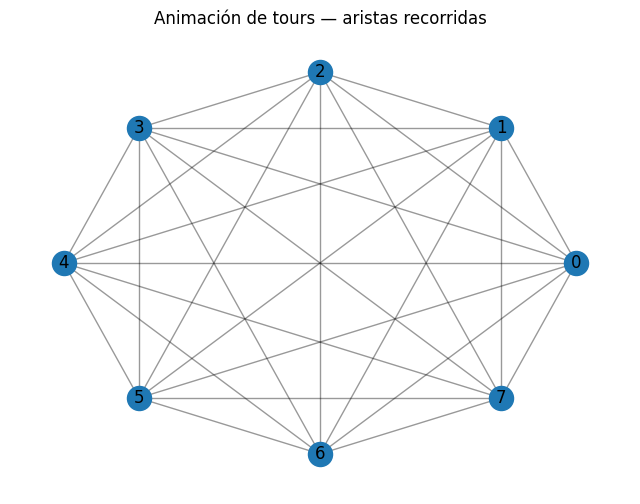

MovieWriter ffmpeg unavailable; using Pillow instead.


Mostrando animación tours_animation_off.gif:


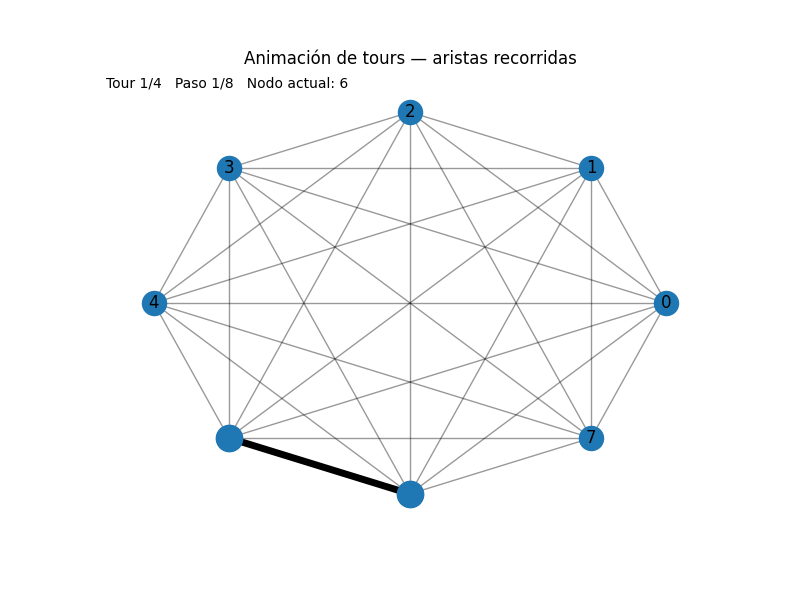

In [17]:
anim_tour(G,[tour_tri,tour_rand,tour_nn,tour_opt])

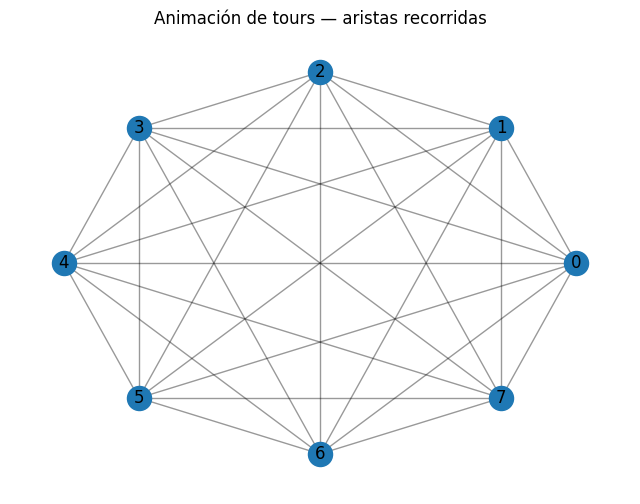

MovieWriter ffmpeg unavailable; using Pillow instead.


Mostrando animación tours_animation.gif:


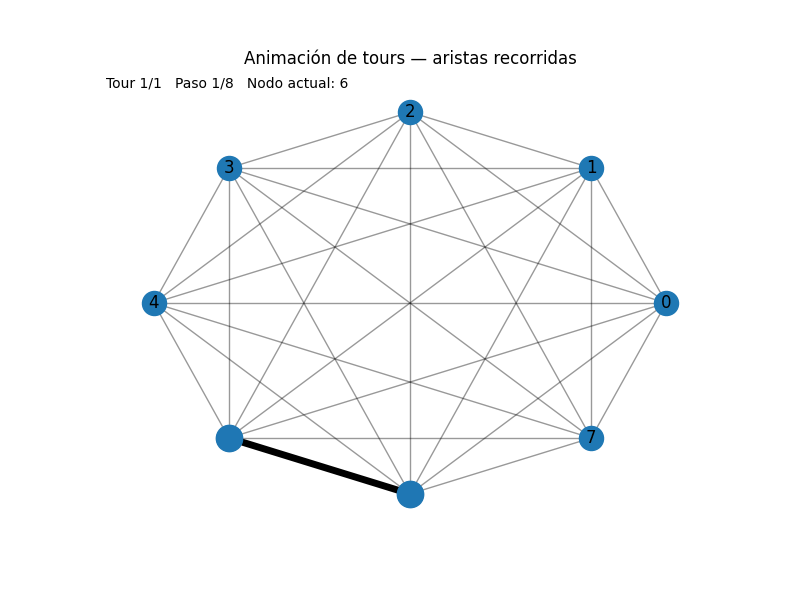

In [18]:
# posiciones para dibujar (fijas para que la animación no salte)
pos = nx.circular_layout(G)

anim = animate_tours(G, [tour_tri], pos=pos, interval=600)
# Para guardar (opcional)
anim.save('tours_animation.gif', fps=1000/600)  # necesita ffmpeg

from IPython.display import Image, display

# Muestra el GIF que acabamos de guardar
print("Mostrando animación tours_animation.gif:")
display(Image(filename='tours_animation.gif'))

# Opcional: Si quieres descargar el archivo a tu PC, usa:
# from google.colab import files
# files.download('tours_animation.gif')

In [19]:
def construir_df_resultados(nombre_politica, tour_tri, eval_tri,
                            tour_rand, eval_rand,
                            tour_nn, eval_nn,
                            tour_opt, eval_opt):
    
    return pd.DataFrame([
        ["Trivial",       nombre_politica, eval_tri["total_value"], eval_tri["total_time"], eval_tri["final_benefit"], tour_tri],
        ["Aleatorio",     nombre_politica, eval_rand["total_value"], eval_rand["total_time"], eval_rand["final_benefit"], tour_rand],
        ["Vecino cercano",nombre_politica, eval_nn["total_value"],  eval_nn["total_time"],  eval_nn["final_benefit"],  tour_nn],
        ["Óptimo",        nombre_politica, eval_opt["total_value"], eval_opt["total_time"], eval_opt["final_benefit"], tour_opt],
    ], columns=["tour","política","valor","tiempo","beneficio","camino"])

df_greedy   = construir_df_resultados("Greedy",   tour_tri, eval_tri,  tour_rand, eval_rand, tour_nn, eval_nn, tour_opt, eval_opt)
df_all      = construir_df_resultados("All",      tour_tri, eval_tri_all, tour_rand, eval_rand_all, tour_nn, eval_nn_all, tour_opt_all, eval_opt_all)
df_exchange = construir_df_resultados("Exchange", tour_tri, eval_tri_ex,  tour_rand, eval_rand_ex, tour_nn, eval_nn_ex, tour_opt_ex, eval_opt_ex)

df_res = pd.concat([df_greedy, df_all, df_exchange], ignore_index=True)


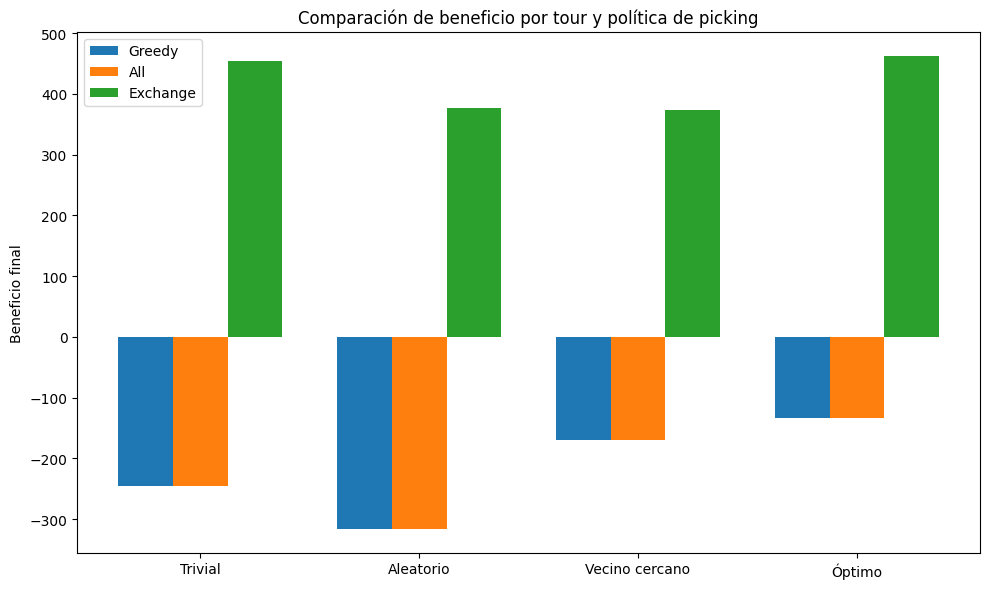

In [20]:
orden_tours = ["Trivial","Aleatorio","Vecino cercano","Óptimo"]
df_res["tour"] = pd.Categorical(df_res["tour"], categories=orden_tours, ordered=True)

plt.figure(figsize=(10,6))

politicas = df_res["política"].unique()
bar_width = 0.25

for i, pol in enumerate(politicas):
    sub = df_res[df_res["política"] == pol].sort_values("tour")
    x = np.arange(len(sub))
    offset = (i - (len(politicas)-1)/2)*bar_width
    plt.bar(x + offset, sub["beneficio"], width=bar_width, label=pol)

plt.xticks(range(len(orden_tours)), orden_tours)
plt.ylabel("Beneficio final")
plt.title("Comparación de beneficio por tour y política de picking")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\crist\AppData\Local\Temp\ipykernel_23968\3396474711.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabla = df_res.pivot_table(index="política", columns="tour", values="beneficio")


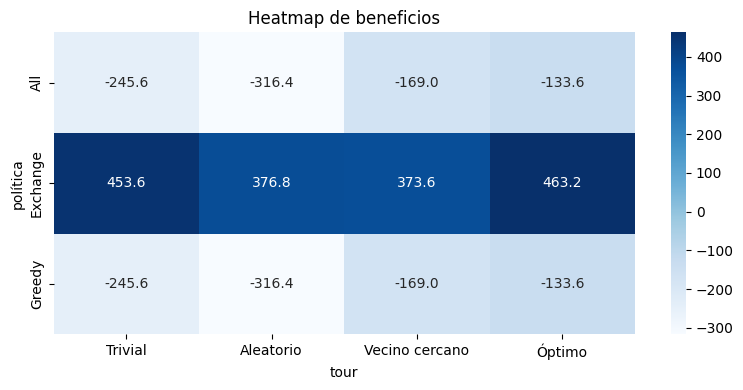

In [21]:
tabla = df_res.pivot_table(index="política", columns="tour", values="beneficio")

plt.figure(figsize=(8,4))
sns.heatmap(tabla, annot=True, cmap="Blues", fmt=".1f")
plt.title("Heatmap de beneficios")
plt.tight_layout()
plt.show()